In [1]:
import ee
import time
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from google.auth.transport.requests import Request
from google_auth_oauthlib.flow import InstalledAppFlow
import pickle
import os
import io
from googleapiclient.http import MediaIoBaseDownload
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.warp import reproject, Resampling
from pydantic import BaseModel
import osmnx as ox

In [2]:
class ExtractBox(BaseModel):
    location: str
    distance: float = 1000.0  # Default distance in meters
    filepath: str

def extract_bbox(**kwargs):
    input = ExtractBox(**kwargs)
    location = input.location
    distance = input.distance
    filepath = input.filepath

    # Generate GeoDataFrame from location
    gdf = ox.geocode_to_gdf(location)
    gdf.to_file(filepath, driver="GeoJSON")
    print(f"✅ GeoJSON file saved as {filepath}")

    # Compute bounding box
    minx, miny, maxx, maxy = gdf.total_bounds

    # ✅ Return structured output
    return {
        "file_path": filepath,
        "bbox": [minx, miny, maxx, maxy]
    }

In [3]:
bbox = extract_bbox(location="varanasi", distance=1000, filepath="varansi.geojson")["bbox"]


✅ GeoJSON file saved as varansi.geojson


In [4]:
import time
def task_status_view(task):
    
    # Monitor task state every 10 seconds
    while task.status()['state'] in ['READY', 'RUNNING']:
        print(f"⏳ Task state: {task.status()['state']}")
        time.sleep(2)

    # Final result
    print(f"✅ Task complete! Final state: {task.status()['state']}")
    if(task.status()['state'] == 'COMPLETED'):
        return True
    else:
        return False


In [14]:
import ee

# Step 1: Authenticate and initialize
def ee_auth():
    ee.Authenticate(scopes=[
        'https://www.googleapis.com/auth/drive',
        'https://www.googleapis.com/auth/earthengine'
    ])
    ee.Initialize()

In [6]:
import os
import io
import time
import pickle
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request

# 🔐 Step 1: One-time login + token reuse
def get_drive_service(
    scopes=['https://www.googleapis.com/auth/drive'],
    creds_path='credentials.json',
    token_path='token.pickle'
):
    creds = None

    # Load existing token
    if os.path.exists(token_path):
        with open(token_path, 'rb') as token:
            creds = pickle.load(token)

    # If no valid credentials, run browser auth
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(creds_path, scopes)
            creds = flow.run_local_server(port=0)
        # Save the token
        with open(token_path, 'wb') as token:
            pickle.dump(creds, token)

    # Return Drive service
    return build('drive', 'v3', credentials=creds)


def delete_drive_file(filename,
    folder_name = "EarthEngine",
    creds_path='credentials.json',
    retries=3,
    delay=5):
    """
    Delete a file named `filename.tif` from the given Google Drive folder using Google Drive API service.
    Args:
        service: Authenticated Google Drive API service object (from get_drive_service()).
        filename: Name of the file to delete (without extension).
        folder_name: Google Drive folder name where the file is stored.
    """
    service= get_drive_service()
    try:
        # Step 1: Get folder ID by name
        folder_results = service.files().list(
            q=f"name='{folder_name}' and mimeType='application/vnd.google-apps.folder' and trashed=false",
            spaces='drive',
            fields="files(id, name)",
            pageSize=1
        ).execute()

        folders = folder_results.get('files', [])
        if not folders:
            print(f"❌ Folder '{folder_name}' not found in your Drive.")
            return

        folder_id = folders[0]['id']

        # Step 2: Search for file in that folder
        query = f"name='{filename}.tif' and '{folder_id}' in parents and trashed=false"
        file_results = service.files().list(
            q=query,
            spaces='drive',
            fields="files(id, name)",
            pageSize=1
        ).execute()

        files = file_results.get('files', [])
        if not files:
            print(f"⚠️ No existing file named '{filename}.tif' found in folder '{folder_name}'.")
            return

        # Step 3: Delete the file
        file_id = files[0]['id']
        service.files().delete(fileId=file_id).execute()
        print(f"✅ Deleted old file '{filename}.tif' from Google Drive folder '{folder_name}'.")

    except Exception as e:
        print(f"❌ Error deleting file from Drive: {e}")





# 🔽 Step 2: Download file from Drive by name
def download_from_drive(
    filename,
    download_dir='downloads',
    creds_path='credentials.json',
    retries=3,
    delay=5
):
    service = get_drive_service(creds_path=creds_path)

    for attempt in range(1, retries + 1):
        # Search for the file in Drive
        print(f"🔍 Searching for '{filename}' on Drive...")
        results = service.files().list(
            q=f"name='{filename}' and trashed=false",
            spaces='drive',
            fields='files(id, name)',
        ).execute()
        items = results.get('files', [])

        if items:
            file_id = items[0]['id']
            request = service.files().get_media(fileId=file_id)

            # Prepare output path
            os.makedirs(download_dir, exist_ok=True)
            local_path = os.path.join(download_dir, filename)

            # Start download
            fh = io.FileIO(local_path, 'wb')
            downloader = MediaIoBaseDownload(fh, request)

            done = False
            while not done:
                status, done = downloader.next_chunk()
                if status:
                    print(f"⬇️ Downloading '{filename}': {int(status.progress() * 100)}%")

            print(f"✅ Download complete: {local_path}")
            return local_path  # return full local path

        elif attempt < retries:
            print(f"❌ File not found. Retrying in {delay} seconds... (Attempt {attempt}/{retries})")
            time.sleep(delay)
        else:
            raise FileNotFoundError(f"❌ File '{filename}' not found in Drive after {retries} attempts.")


In [7]:
class GetData( BaseModel ):
    bbox: list
    filepath: str

In [15]:
def get_temp (**kwargs):
    input = GetData(**kwargs)
    bbox = input.bbox
    filepath = input.filepath
    ee_auth() 
    base_name = "downloads"
    delete_drive_file(filepath)
    bbox_geom = ee.Geometry.Rectangle(bbox)

    
    temp = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY") \
    .filterDate('1991-01-01', '2020-12-31') \
    .select('temperature_2m') \
    .mean().subtract(273.15)  
    task = ee.batch.Export.image.toDrive(
        image=temp.clip(bbox_geom),
        description=f"{filepath}",
        folder= 'EarthEngine',
        fileNamePrefix=f"{filepath}",
        region=bbox_geom , 
        scale=500,
        fileFormat='GeoTIFF',
        maxPixels=1e9 
    )
    task.start()
    if(task_status_view(task)):
        # Wait for task to complete'
        time.sleep(5)
        download_from_drive(filepath+".tif", download_dir="downloads")
        filepath = os.path.join(base_name, filepath + ".tif")
        
    return {"filepath": filepath}
    




In [16]:
temp_file = get_temp(bbox=bbox, filepath="varansi_temp")["filepath"]

⚠️ No existing file named 'varansi_temp.tif' found in folder 'EarthEngine'.


c:\ProgramData\anaconda3\Lib\site-packages\ee\deprecation.py:207: DeprecationWarning: 

Attention required for ECMWF/ERA5_LAND/MONTHLY! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_MONTHLY

  warnings.warn(warning, category=DeprecationWarning)


⏳ Task state: READY
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
✅ Task complete! Final state: COMPLETED
🔍 Searching for 'varansi_temp.tif' on Drive...
⬇️ Downloading 'varansi_temp.tif': 100%
✅ Download complete: downloads\varansi_temp.tif


In [17]:
def get_precipitation (**kwargs):
    input = GetData(**kwargs)
    bbox = input.bbox
    filepath = input.filepath
    ee_auth() 
    base_name = "downloads"
    delete_drive_file(filepath)
    bbox_geom = ee.Geometry.Rectangle(bbox)

    
    precip = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY") \
    .filterDate('1991-01-01', '2020-12-31') \
    .select('total_precipitation') \
    .mean().multiply(1000)  
    task = ee.batch.Export.image.toDrive(
        image=precip.clip(bbox_geom),
        description=f"{filepath}",
        folder= 'EarthEngine',
        fileNamePrefix=f"{filepath}",
        region=bbox_geom , 
        scale=500,
        fileFormat='GeoTIFF',
        maxPixels=1e9 
    )
    task.start()
    if(task_status_view(task)):
        # Wait for task to complete'
        time.sleep(5)
        download_from_drive(filepath+".tif", download_dir="downloads")
        filepath = os.path.join(base_name, filepath + ".tif")
        
    return {"filepath": filepath}
    




In [18]:
precipitation = get_precipitation(bbox=bbox, filepath="varansi_precipitation")["filepath"]

⚠️ No existing file named 'varansi_precipitation.tif' found in folder 'EarthEngine'.
⏳ Task state: READY
⏳ Task state: READY
⏳ Task state: READY
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: COMPLETED
✅ Task complete! Final state: COMPLETED
🔍 Searching for 'varansi_precipitation.tif' on Drive...
⬇️ Downloading 'varansi_precipitation.tif': 100%
✅ Download complete: downloads\varansi_precipitation.tif


In [19]:

def get_landcover(**kwargs):
    input = GetData(**kwargs)
    bbox = input.bbox
    filepath = input.filepath
    base_name = "downloads"
    ee_auth()
    bbox_geom = ee.Geometry.Rectangle(bbox)
    delete_drive_file(filepath)
    # --- Use ESA WorldCover 2021 (v200) ---
    lulc_img = ee.Image("ESA/WorldCover/v200/2021").select('Map')

    # --- Export Task to Google Drive ---
    task = ee.batch.Export.image.toDrive(
        image=lulc_img.clip(bbox_geom),
        description=filepath,
        folder='earthengine',
        fileNamePrefix=filepath,
        scale=500,
        region=bbox,
        maxPixels=1e9
    )

    task.start()
    if(task_status_view(task)):
        # Wait for task to complete'
        time.sleep(5)
        download_from_drive(filepath+".tif", download_dir="downloads")
        filepath = os.path.join(base_name, filepath + ".tif")
        
    return {"filepath": filepath}



In [20]:
landcover = get_landcover(bbox=bbox, filepath="varansi_landcover")["filepath"]

⚠️ No existing file named 'varansi_landcover.tif' found in folder 'EarthEngine'.
⏳ Task state: READY
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
✅ Task complete! Final state: COMPLETED
🔍 Searching for 'varansi_landcover.tif' on Drive...
⬇️ Downloading 'varansi_landcover.tif': 100%
✅ Download complete: downloads\varansi_landcover.tif


In [21]:
weights = {
    'temp': 0.3,
    'precip': 0.3,
    'et': 0.2,
    'lulc': 0.2
}

In [23]:
def score_lulc(arr):
    lulc_weights = {
            10: 0.2, 20: 0.3, 30: 0.3, 40: 0.6, 50: 0.9,
            60: 0.4, 70: 0.1, 80: 0.8, 90: 0.7, 95: 0.6, 100: 0.2
    }   
    scored = np.zeros_like(arr, dtype=float)
    for k, v in lulc_weights.items():
        scored[arr == k] = v
    scored[arr == 255] = np.nan
    return scored

In [34]:
landcover = "downloads/varansi_landcover.tif"

In [29]:
from pydantic import BaseModel, Field
from typing import List, TypedDict

class Analysis(BaseModel):
    class RasterConfig(BaseModel):
        filepath: str
        weight: float
        inverse: bool
        raster_type :str 

    filepath_list: List[RasterConfig]
    state_name : str 



In [46]:
def export_classified_raster(array, meta, output_path):
    meta = meta.copy()
    meta.update({
        'dtype': 'int32',
        'count': 1,
        'nodata': 0
    })
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(array.astype(np.int32), 1)


def suitability_analysis(**kwargs):
    input = Analysis(**kwargs)
    filepath_list = input.filepath_list
    state_name = input.state_name
    region = state_name
    formatted_state = region.replace(" ", "") if " " in region else region

    def load_and_resample(path, reference_meta=None):
        with rasterio.open(path) as src:
            data = src.read(1).astype(np.float32)
            if reference_meta is None:
                return data, src.meta
            else:
                dst_array = np.empty((reference_meta['height'], reference_meta['width']), dtype=np.float32)
                reproject(
                    source=data,
                    destination=dst_array,
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=reference_meta['transform'],
                    dst_crs=reference_meta['crs'],
                    resampling=Resampling.bilinear
                )
                return dst_array, reference_meta

    def normalize(x, inverse=False):
        x = np.where(np.isnan(x), 0, x)
        min_val, max_val = np.min(x), np.max(x)
        if max_val - min_val == 0:
            return np.zeros_like(x)
        norm = (x - min_val) / (max_val - min_val)
        return 1 - norm if inverse else norm

    # Load first raster to get reference metadata
    _, ref_meta = load_and_resample(filepath_list[0].filepath)

    combined = np.zeros((ref_meta['height'], ref_meta['width']), dtype=np.float32)

    # LULC class weights
    lulc_weights = {
        10: 0.2, 20: 0.3, 30: 0.3, 40: 0.6, 50: 0.9,
        60: 0.4, 70: 0.1, 80: 0.8, 90: 0.7, 95: 0.6, 100: 0.2
    }

    for raster in filepath_list:
        arr, _ = load_and_resample(raster.filepath, ref_meta)

        if raster.raster_type.lower() == "lulc":
            arr = np.vectorize(lambda x: lulc_weights.get(int(x), 0.3))(arr)

        norm_arr = normalize(arr, inverse=raster.inverse)
        combined += norm_arr * raster.weight

    # --- Classification ---
    classification_bins = [0.2, 0.4, 0.6, 0.8]
    classified = np.digitize(combined, bins=classification_bins)

    # --- Plot ---
    plt.figure(figsize=(10, 6))
    im = plt.imshow(classified, cmap='RdYlBu_r')
    plt.title(f" Suitability Map ({state_name})", fontsize=14)
    cbar = plt.colorbar(im, ticks=[1, 2, 3, 4])
    cbar.ax.set_yticklabels(["Low", "Moderate", "High", "Very High"])
    cbar.set_label("Suitability Classification", rotation=270, labelpad=15)
    plt.axis('off')
    plt.show()

    # --- Save output raster ---
    output_path = os.path.join("outputs", f"{formatted_state}_suitability_map.tif")
    export_classified_raster(classified, ref_meta, output_path)

    return {"classified_raster": output_path}


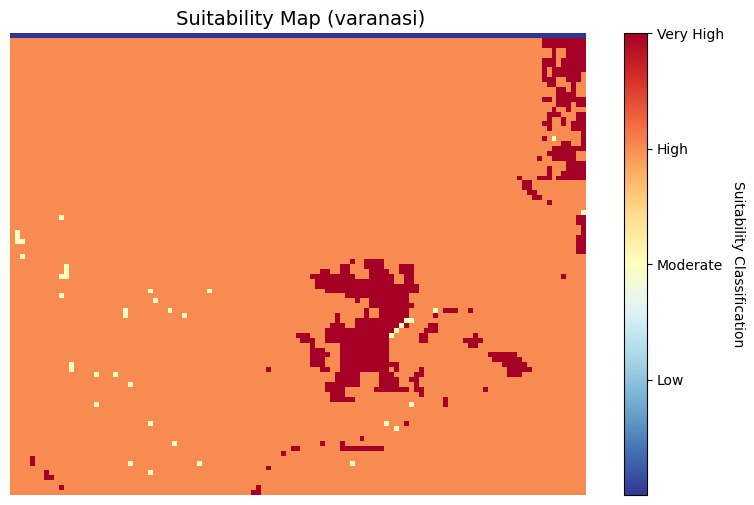

In [45]:
final = suitability_analysis(state_name = "varanasi" , 
                             filepath_list=[
    Analysis.RasterConfig(filepath=temp_file, weight=weights['temp'], inverse=False, raster_type="temperature"),
    Analysis.RasterConfig(filepath=precipitation, weight=weights['precip'], inverse=False, raster_type="precipitation"),
    Analysis.RasterConfig(filepath=landcover, weight=weights['lulc'], inverse=False,         raster_type="lulc"),
])["classified_raster"]

In [37]:
final

'outputs\\varanasi_suitability_map.tif'

In [36]:
import rasterio
from rasterio.mask import mask
from rasterio.transform import array_bounds
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import os

class VisualiseMap(BaseModel):
    raster_path: str
    boundary_geojson_path: str
    output_png_path: str
    output_html_path: str
    colormap: str = 'RdYlBu_r'
    opacity: float = 0.6
    zoom_start: int = 8

def visualise_map(
    **kwargs
):
    input = VisualiseMap(**kwargs)
    raster_path = input.raster_path
    boundary_geojson_path = input.boundary_geojson_path
    output_png_path = input.output_png_path
    output_html_path = input.output_html_path
    colormap = input.colormap
    opacity = input.opacity
    zoom_start = input.zoom_start
    # --- Ensure output directories exist ---
    # --- Load boundary ---
    gdf = gpd.read_file(boundary_geojson_path)

    # --- Clip raster to boundary ---
    with rasterio.open(raster_path) as src:
        gdf = gdf.to_crs(src.crs)  # Ensure CRS match
        clipped, clipped_transform = mask(src, gdf.geometry, crop=True)
        clipped_meta = src.meta.copy()

    # --- Normalize for display ---
    raster_data = clipped[0]
    raster_data = np.where(raster_data == 0, np.nan, raster_data)
    norm_data = (raster_data - np.nanmin(raster_data)) / (np.nanmax(raster_data) - np.nanmin(raster_data))

    # --- Save RGB image using colormap ---
    cmap = plt.get_cmap(colormap)
    rgba_img = cmap(norm_data)
    plt.imsave(output_png_path, rgba_img)

    # --- Compute bounds ---
    height, width = raster_data.shape
    minx, miny, maxx, maxy = array_bounds(height, width, clipped_transform)
    center_lat = (miny + maxy) / 2
    center_lon = (minx + maxx) / 2

    # --- Build Folium map ---
    m = folium.Map(location=[center_lat, center_lon], zoom_start=zoom_start, tiles="OpenStreetMap")

    image_overlay = folium.raster_layers.ImageOverlay(
        name='Flood Risk (Clipped)',
        image=output_png_path,
        bounds=[[miny, minx], [maxy, maxx]],
        opacity=opacity,
        interactive=True,
        cross_origin=False,
        zindex=1
    )

    image_overlay.add_to(m)
    folium.LayerControl().add_to(m)
    m.save(output_html_path)

    print(f"✅ Map created: {output_html_path}")


In [41]:
visualise_map(
    raster_path=final,
    boundary_geojson_path="varansi.geojson",
    output_png_path="flood_risk_map.png",
    output_html_path="flood_risk_map.html",
    colormap='RdYlBu_r',
    opacity=0.6,
    zoom_start=8
)


✅ Map created: flood_risk_map.html
